In [1]:
import pandas as pd
import json
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
import nltk
from sklearn.tree import DecisionTreeClassifier
#import keras
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
import re

In [2]:
# 加载 JSON 数据
tweets_data = []
with open('tweets_DM.json', 'r') as file:
    for line in file:
        tweet = json.loads(line)
        # 提取嵌套字段 _source.tweet
        tweet_data = tweet.get('_source', {}).get('tweet', {})
        tweets_data.append(tweet_data)

# 转换为 DataFrame
tweets_df = pd.DataFrame(tweets_data)

# 查看结果
print(tweets_df.head())


                        hashtags  tweet_id  \
0                     [Snapchat]  0x376b20   
1  [freepress, TrumpLegacy, CNN]  0x2d5350   
2                   [bibleverse]  0x28b412   
3                             []  0x1cd5b0   
4                             []  0x2de201   

                                                text  
0  People who post "add me on #Snapchat" must be ...  
1  @brianklaas As we see, Trump is dangerous to #...  
2  Confident of your obedience, I write to you, k...  
3                Now ISSA is stalking Tasha 😂😂😂 <LH>  
4  "Trust is not the same as faith. A friend is s...  


In [3]:
# 加载 CSV 文件
emotion = pd.read_csv('emotion.csv')
data_identification = pd.read_csv('data_identification.csv')

# 合并数据：推文内容与情绪标签
tweets_with_emotion = pd.merge(tweets_df, emotion, on='tweet_id', how='left')

# 合并数据：训练/测试集标识
complete_data = pd.merge(tweets_with_emotion, data_identification, on='tweet_id', how='left')

# 查看结果
print(complete_data.head())


                        hashtags  tweet_id  \
0                     [Snapchat]  0x376b20   
1  [freepress, TrumpLegacy, CNN]  0x2d5350   
2                   [bibleverse]  0x28b412   
3                             []  0x1cd5b0   
4                             []  0x2de201   

                                                text       emotion  \
0  People who post "add me on #Snapchat" must be ...  anticipation   
1  @brianklaas As we see, Trump is dangerous to #...       sadness   
2  Confident of your obedience, I write to you, k...           NaN   
3                Now ISSA is stalking Tasha 😂😂😂 <LH>          fear   
4  "Trust is not the same as faith. A friend is s...           NaN   

  identification  
0          train  
1          train  
2           test  
3          train  
4           test  


In [4]:


# 清理推文文本
def clean_text(text):
    text = re.sub(r"http\S+", "", text)  # 去除URL
    text = re.sub(r"[^\w\s#@]", "", text)  # 保留文字、# 和 @
    return text.strip()

complete_data['text'] = complete_data['text'].apply(clean_text)
complete_data=complete_data.drop(['hashtags'],axis=1)

In [5]:
complete_data

,tweet_id,text,emotion,identification
0,0x376b20,People who post add me on #Snapchat must be de...,anticipation,train
1,0x2d5350,@brianklaas As we see Trump is dangerous to #f...,sadness,train
2,0x28b412,Confident of your obedience I write to you kno...,NaN,test
3,0x1cd5b0,Now ISSA is stalking Tasha LH,fear,train
4,0x2de201,Trust is not the same as faith A friend is som...,NaN,test
...,...,...,...,...
1867530,0x316b80,When you buy the last 2 tickets remaining for ...,NaN,test
1867531,0x29d0cb,I swear all this hard work gone pay off one da...,NaN,test
1867532,0x2a6a4f,@Parcel2Go no card left when I wasnt in so I h...,NaN,test
1867533,0x24faed,Ah corporate life where you can date LH using ...,joy,train


In [6]:
train_df = complete_data[complete_data['identification'] == 'train']
test_df = complete_data[complete_data['identification'] == 'test']
print(train_df)
print(test_df)

         tweet_id                                               text  \
0        0x376b20  People who post add me on #Snapchat must be de...   
1        0x2d5350  @brianklaas As we see Trump is dangerous to #f...   
3        0x1cd5b0                     Now ISSA is stalking Tasha  LH   
5        0x1d755c  @RISKshow @TheKevinAllison Thx for the BEST TI...   
6        0x2c91a8          Still waiting on those supplies Liscus LH   
...           ...                                                ...   
1867526  0x321566  Im SO HAPPY #NoWonder the name of this show #H...   
1867527  0x38959e  In every circumtance Id like to be thankful to...   
1867528  0x2cbca6  theres currently two girls walking around the ...   
1867533  0x24faed  Ah corporate life where you can date LH using ...   
1867534  0x34be8c               Blessed to be living #Sundayvibes LH   

              emotion identification  
0        anticipation          train  
1             sadness          train  
3                f

In [7]:
test_ids=test_df['tweet_id']

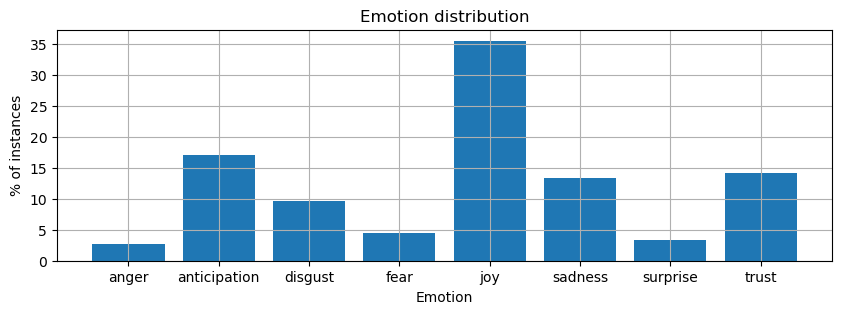

In [8]:
# the histogram of the data
labels = train_df['emotion'].unique()
post_total = len(train_df)
df1 = train_df.groupby(['emotion']).count()['text']
df1 = df1.apply(lambda x: round(x*100/post_total,3))
#plot
fig, ax = plt.subplots(figsize=(10,3))
plt.bar(df1.index,df1.values)
#arrange
plt.ylabel('% of instances')
plt.xlabel('Emotion')
plt.title('Emotion distribution')
plt.grid(True)
plt.show()


In [9]:
# build analyzers (bag-of-words)
BOW_500 = CountVectorizer(max_features=1300, tokenizer=nltk.word_tokenize) 
# apply analyzer to training data
BOW_500.fit(train_df['text'])
train_data_BOW_features_500 = BOW_500.transform(train_df['text'])
## check dimension
train_data_BOW_features_500.shape

C:\Users\User\anaconda3\Lib\site-packages\sklearn\feature_extraction\text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


KeyboardInterrupt: 

In [ ]:
# for a classificaiton problem, you need to provide both training & testing data
X_train = BOW_500.transform(train_df['text'])
y_train = train_df['emotion']
X_test = BOW_500.transform(test_df['text'])
y_test = test_df['emotion']
 ## take a look at data dimension is a good habit  :)
print('X_train.shape: ', X_train.shape)
print('y_train.shape: ', y_train.shape)
print('X_test.shape: ', X_test.shape)
print('y_test.shape: ', y_test.shape)

In [ ]:
# 定义模型列表
models = {
    "DecisionTree": DecisionTreeClassifier(random_state=1),
    "RandomForest": RandomForestClassifier(random_state=1, n_estimators=100),
    "LogisticRegression": LogisticRegression(random_state=1)
}

# 训练和保存预测结果
for model_name, model in models.items():
    print(f"Training {model_name}...")
    
    # 训练模型
    model.fit(X_train, y_train)
    
    # 预测测试集
    y_test_pred = model.predict(X_test)
    
    # 保存预测结果
    predictions = pd.DataFrame({
        'id': test_ids,  # 假设 test_data 中包含 `tweet_id`
        'emotion': y_test_pred
    })
    result_file = f'{model_name}_predictions.csv'
    predictions.to_csv(result_file, index=False)
    print(f"Predictions saved to {result_file}")